# Virtual Captive Tests (VCT)
```{figure} reference_frame.png
---
name: reference_frame
---
Drift angle test - measuring the forces at a certain speed and drift angle.
```

![](reference_frame.png)

In [186]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Import pyMC3 and also arviz for visualisation
import pymc as pm
import arviz as az
import sympy as sp
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('bmh')
import symseaman as ss
from symseaman.substitute_dynamic_symbols import lambdify, remove_bis_eq, run, standard_substitutes
from symseaman.seaman_symbols import *
from vct.bis_system import BisSystem

[03/24/23 10:15:02] WARNING  Using NumPy C-API based implementation for BLAS functions.        ]8;id=135910;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/pytensor/tensor/blas_headers.py\blas_headers.py]8;;\:]8;id=610784;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/pytensor/tensor/blas_headers.py#1016\1016]8;;\

In [57]:
import sympy as sp
from symseaman.seaman_symbols import *
from symseaman.substitute_dynamic_symbols import run, lambdify, standard_substitutes, remove_bis, remove_bis_eq, standard_substitutes_eq, lower_and_abs
from symseaman.seaman_symbol import BisSymbol
import symseaman as ss
from symseaman.seaman_symbol import expand_bis
from symseaman.shipdict import ShipDict
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
pd.set_option('max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 9,7
plt.style.use('bmh')
import vct.bokeh_plotting as bokeh_plotting
from numpy.testing import assert_almost_equal
from scipy.interpolate import interp1d
from symseaman.calculate import calculate_ship
from symseaman.to_matrix import matrix_form, matrix_form_standard, exclude, exclude_derivatives
from functools import reduce
from operator import add
from vct.regression_ols import Regression, RegressionPipeline
import dill
import seaborn as sns
from myst_nb import glue

In [207]:
# Read configs:
import anyconfig
globals_path = "../../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]
from vct.bis_system import BisSystem
import statsmodels.api as sm
from scipy.stats import norm
from vct.regression_ols import data_to_bis
from scipy.stats import norm, multivariate_normal

In [95]:
%reload_kedro
ship_name=ships[0]
shipdict = catalog.load(f"{ship_name}.shipdict_base")
ship_dict_from_regression = catalog.load(f"{ ship_name }.ship_dict_from_regression")

df_VCT = catalog.load(f"{ship_name}.df_VCT")
df_VCT['g'] = df_VCT['g'].fillna(method='pad')
df_VCT['rho'] = df_VCT['rho'].fillna(method='pad')
df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])

df_VCT['fx_hull'] = df_VCT['fx']  # Not true but works for this example...
df_VCT['fy_hull'] = df_VCT['fy']  # Not true but works for this example...
df_VCT['mz_hull'] = df_VCT['mz']  # Not true but works for this example...

thrust_keys = catalog.load(f"params:{ship_name}.thrust_keys")

if len(thrust_keys) > 0:
    df_VCT['tprop'] = df_VCT[thrust_keys[0]]
else:
    df_VCT['tprop'] = 0
    thrust_keys=['tprop']
    
derivatives = catalog.load(f"{ship_name}.derivatives")["OLS"]
derivatives_std = catalog.load(f"{ship_name}.derivatives_std")["OLS"]

Loading BokehJS ...

[03/24/23 15:05:47] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=320079;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=42437;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[03/24/23 15:05:49] INFO     Kedro project phd                                                      ]8;id=656617;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=593056;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=813576;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=106280;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from 'M5064-02-A.shipdict_base' (ShipDictDataSet)...  ]8;id=494725;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=232766;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'M5064-02-A.ship_dict_from_regression'           ]8;id=35086;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=86426;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (IncrementalDataSet)...                                                               

                    INFO     Loading data from 'M5064-02-A.df_VCT' (CSVDataSet)...              ]8;id=235468;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=8269;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:M5064-02-A.thrust_keys'                  ]8;id=774925;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=84827;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'M5064-02-A.derivatives' (IncrementalDataSet)... ]8;id=174059;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=751935;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'M5064-02-A.derivatives_std'                     ]8;id=361580;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=709229;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (IncrementalDataSet)...                                                               

```{glue:figure} vct_drift
:name: "vct_drift"

Transverse force from drift angle variations with VCT for two ship speeds.
```

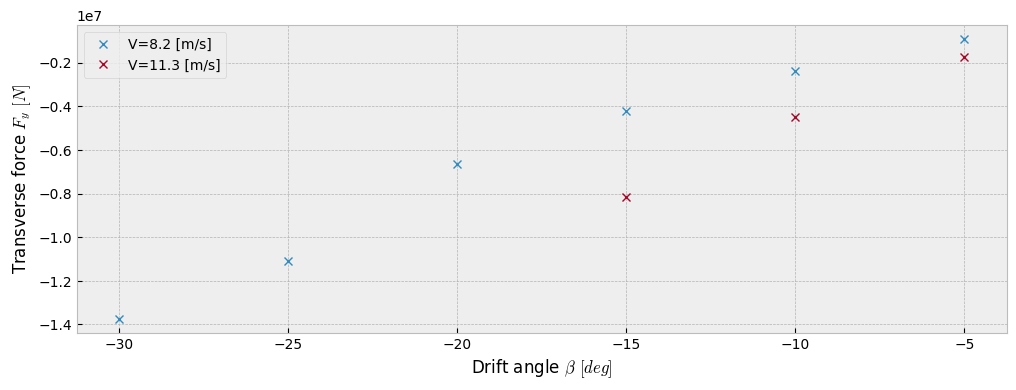

In [201]:
df_ = df_VCT.groupby(by='test type').get_group('Drift angle')
fig,ax=plt.subplots()
for V_, group in df_.groupby(by='V'):
    group.plot(x='beta_deg', y='fy', style='x', label=f"V={np.round(V_,decimals=1)} [m/s]", ax=ax)
ax.set_xlabel(r'Drift angle $\beta$ $[deg]$')
ax.set_ylabel(r'Transverse force $F_y$ $[N]$');
glue("vct_drift",fig, display=False)

In [144]:
units={
    
    'fx_hull':'force',
    'fy_hull':'force',
    'mz_hull':'moment',
      
}

interesting = [
    'fx_hull',
    'fy_hull',
    'mz_hull',
]

df_bis = data_to_bis(df=df_VCT, shipdict=shipdict, units=units, interesting=interesting)

A model to describe the transverse force as function of: the longitudinal speed $u_w$ and transverse speed $v_w$ together with the hydrodynamic derivatives (parameters) $Y_{v|v|}$, $Y_{uv}$, and $Y_{uuv}$:

```{glue:math} eqsway
:name: "eqsway"
```

In [178]:
eq = ss.equations.hull.sway.eq_expanded.subs([
    (phi.bis,0),
    (r_w.bis,0),
    (delta,0),
    #(Y_uuv,0), # Note!
    (Y_h.bis, 'F_y'),
    (u_w.bis, 'u'),
    (v_w.bis, 'v'),
    
    ])
glue("eqsway",remove_bis_eq(eq))

Eq(F_y, Y_{v|v|}*v*Abs(v) + u*v*(Y_uuv*u + Y_uv))

### Regression

In [146]:
class Regression_fy_drift(Regression):
    _eq = ss.equations.hull.sway.eq_expanded.subs([
    (phi.bis,0),
    (r_w.bis,0),
    (delta,0),
    #(Y_uuv,0), # Note!
    ])

In [147]:
pre_set_derivatives_0 = {
}
pipeline = RegressionPipeline(shipdict=shipdict, pre_set_derivatives=pre_set_derivatives_0)

mask = df_bis['test type'].isin(['Drift angle'])
df_ = df_bis.loc[mask]

pipeline['drift'] = Regression_fy_drift(df=df_)

In [148]:
regression = pipeline['drift']
regression.fit(derivatives=pre_set_derivatives_0, meta_data=pipeline.meta_data)

In [149]:
regression.eq_excluded

Eq(Y_h, Y_uuv*u_w**2*v_w + Y_uv*u_w*v_w + Y_{v|v|}*v_w*Abs(v_w))

In [150]:
y,X=regression.label_and_features(derivatives=pre_set_derivatives_0, meta_data=pipeline.meta_data)

Estimation of the hydrodynamic derivatives can be formulated as a linear regression problem:
```{math}
:label: regression
y = X \beta + \epsilon
```

Tthe feature matrix $X$ contains polynomials of the state ($u$ and $v$ here) namely: $u^2 \cdot v$, $u \cdot v$, and $v \cdot |v|$ as given in the following table:

```{glue:figure} features
:name: "features"

Feature matrix $X$.
```

In [151]:
glue("features",X.style.hide_index())

yvav,yuuv,yuv
-0.000234,-0.000467,-0.002672
-0.000928,-0.000909,-0.005263
-0.002061,-0.001304,-0.007693
-0.003600,-0.001630,-0.009890
-0.005496,-0.001874,-0.011787
-0.007693,-0.002024,-0.013325
-0.000442,-0.001214,-0.005052
-0.001754,-0.002363,-0.009950
-0.003897,-0.003389,-0.014545


In [183]:
eq = ss.equations.hull.sway.eq_expanded.subs([
    (phi.bis,0),
    (r_w.bis,0),
    (delta,0),
    #(Y_uuv,0), # Note!
    
    ])
eq

Eq(Y''_h, u''_w*v''_w*(u''_w*Y_uuv + Y_uv) + v''_w*Y_{v|v|}*Abs(v''_w))

In [190]:
lambda_sway = lambdify(eq, convert_to_SI=True)

In [191]:
df_ = df_VCT.groupby(by='test type').get_group('Drift angle')
df_predict = df_.copy()
df_predict['fy_ols'] = run(function=lambda_sway, inputs=df_, l=shipdict.main_data['l'], disp=shipdict.design_particulars['disp'], **regression.regression.params)

```{glue:figure} ols_regression
:name: "ols_regression"

Fitted model with multivariate ordinary least square (OLS) regression.
```

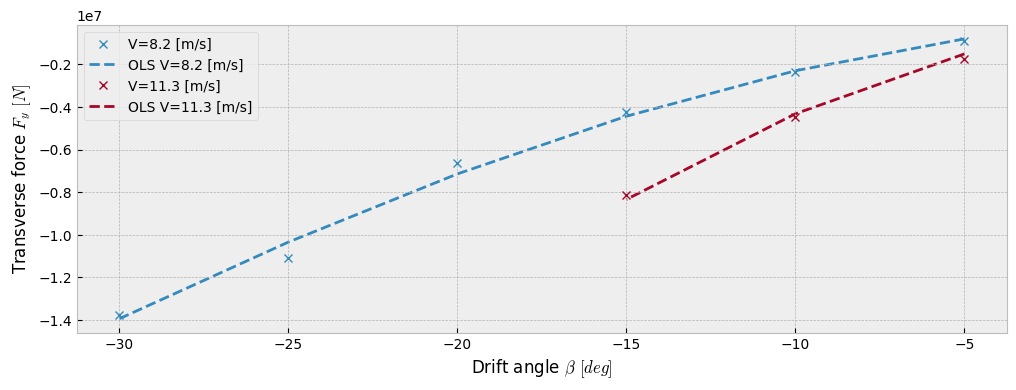

In [200]:
fig,ax=plt.subplots()
for V_, group in df_predict.groupby(by='V'):
    plot = group.plot(x='beta_deg', y='fy', style='x', label=f"V={np.round(V_,decimals=1)} [m/s]", ax=ax)
    color = plot.lines[-1].get_color()
    group.plot(x='beta_deg', y='fy_ols', style='--', color=color, label=f"OLS V={np.round(V_,decimals=1)} [m/s]", zorder=-10, ax=ax)

    ax.set_xlabel(r'Drift angle $\beta$ $[deg]$')
ax.set_ylabel(r'Transverse force $F_y$ $[N]$');
glue("ols_regression",fig, display=False)

```{glue:figure} pairplot
:name: "pairplot"

There is a high correlation between the features associated with each derivative.
```

```{glue:figure} corr
:name: "corr"

There is a high correlation between the features associated with each derivative.
```

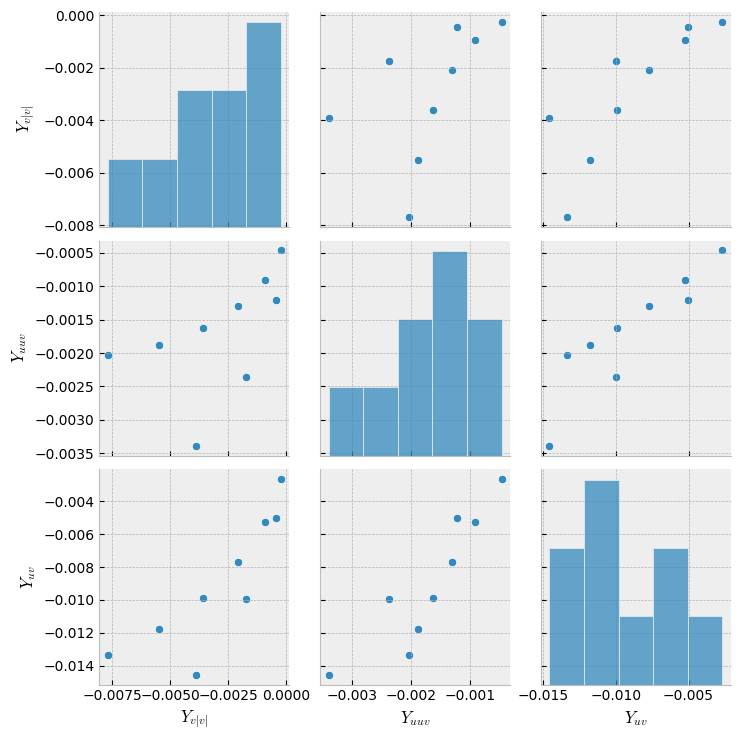

In [204]:
columns_sympy = {
    'yuv':Y_uv,
    'yuuv':Y_uuv,
    'yvav':Y_vav,
}
columns_latex = {key:f"${sp.latex(value)}$" for key,value in columns_sympy.items()}
X_ = X.copy()
X_.rename(columns=columns_latex, index=columns_latex, inplace=True)
grid = sns.pairplot(data=X_)
glue("pairplot",grid.fig, display=False)

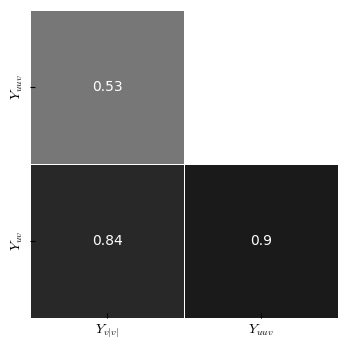

In [205]:
import matplotlib as mpl

corr = X.corr()

columns_sympy = {
    'yuv':Y_uv,
    'yuuv':Y_uuv,
    'yvav':Y_vav,
}
columns_latex = {key:f"${sp.latex(value)}$" for key,value in columns_sympy.items()}
corr.rename(columns=columns_latex, index=columns_latex, inplace=True)

fig,ax=plt.subplots()
ax.set_aspect('equal', 'box')
matrix=np.triu(np.ones((len(corr),len(corr))))

import matplotlib as mpl
cmap = mpl.cm.get_cmap('gray_r')
cmap.set_bad("white")

sns.heatmap(corr.iloc[1:,0:-1], mask=matrix[1:,0:-1], linewidths=.5, annot=True, cmap=cmap, cbar=False, ax=ax, square=True, vmin=0, vmax=1)
ax.grid(False)
glue("corr", fig, display=False)


In [206]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               -fy_hull   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              927.9
Date:                Fri, 24 Mar 2023   Prob (F-statistic):                    2.17e-08
Time:                        15:56:35   Log-Likelihood:                          48.961
No. Observations:                   9   AIC:                                     -91.92
Df Residuals:                       6   BIC:                                     -91.33
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
yvav          -4.7415      0.492     -9.632      0.000      -5.946      -3.537
yuuv           0.1708      1.983      0.086      0.934      -4.681       5.023
yuv           -0.5667      0.529     -1.072      0.325      -1.861       0.727
==============================================================================
Omnibus:                        2.020   Durbin-Watson:                   2.844
Prob(Omnibus):                  0.364   Jarque-Bera (JB):                0.498
Skew:                           0.575   Prob(JB):                        0.780
Kurtosis:                       3.081   Cond. No.                         50.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [236]:
rv = multivariate_normal(mean = regression.regression.params, cov=regression.regression.cov_HC0)
N = 30
df_parameter_variation = pd.DataFrame(data=rv.rvs(N), columns=regression.regression.params.index)

```{glue:figure} boxplots
:name: "boxplots"

Monte-Carlo simulations of the derivatives based on the mean values and covariance matrix from the OLS regression.
```

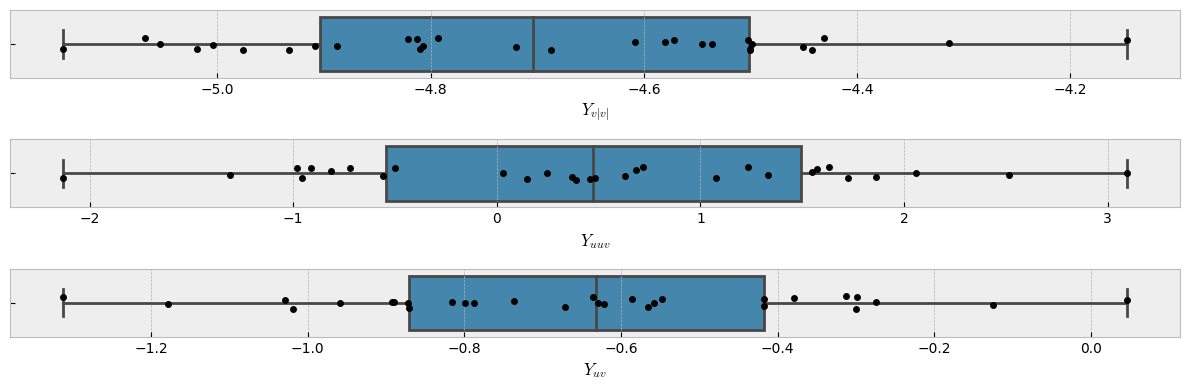

In [260]:
fig,axes=plt.subplots(nrows=len(df_parameter_variation.columns))

for ax,key in zip(axes,df_parameter_variation.columns):
    sns.boxplot(x=df_parameter_variation[key], ax=ax)
    sns.stripplot(x=df_parameter_variation[key], color='black', ax=ax)
    ax.set_xlabel(columns_latex[key])
    
plt.tight_layout()
glue("boxplots",fig, display=False)

In [238]:
_ = []
for index,variation in df_parameter_variation.iterrows():
    
    df_predict_ = df_[['V','beta_deg']].copy()
    df_predict_['fy'] = run(function=lambda_sway, inputs=df_, l=shipdict.main_data['l'], disp=shipdict.design_particulars['disp'], **variation)
    df_predict_[variation.index] = variation
    df_predict_['variation'] = index
    _.append(df_predict_)
    
df_parameter_variation_predictions = pd.concat(_)

```{glue:figure} variations
:name: "variations"

Monte-Carlo simulations of alternative realizations of the derivatives from the OLS regression.
```

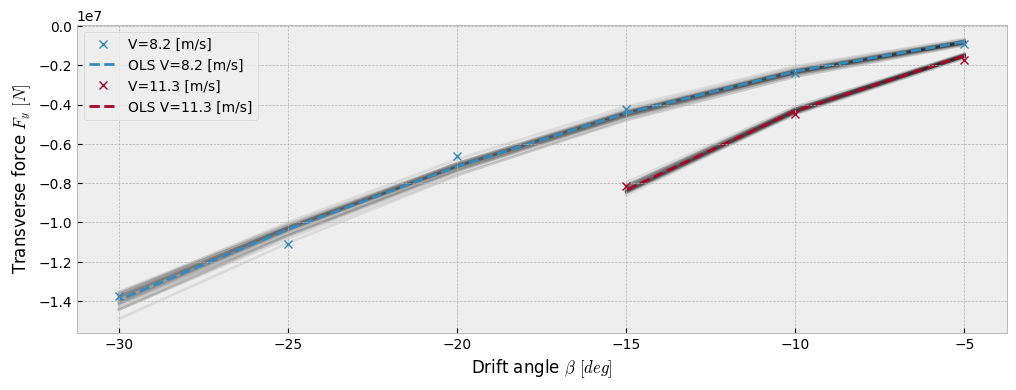

In [261]:
fig,ax=plt.subplots()
for V_, group in df_predict.groupby(by='V'):
    plot = group.plot(x='beta_deg', y='fy', style='x', label=f"V={np.round(V_,decimals=1)} [m/s]", ax=ax)
    color = plot.lines[-1].get_color()
    group.plot(x='beta_deg', y='fy_ols', style='--', color=color, label=f"OLS V={np.round(V_,decimals=1)} [m/s]", zorder=-10, ax=ax)

    for variation, group_variation in df_parameter_variation_predictions.groupby(by='variation'):
        mask = group_variation['V'] == V_
        group_variation.loc[mask].plot(x='beta_deg', y='fy', style='-', color='black', label=f"__none__", zorder=-20, ax=ax, alpha=0.08)
    
    ax.set_xlabel(r'Drift angle $\beta$ $[deg]$')
ax.set_ylabel(r'Transverse force $F_y$ $[N]$');

glue("variations",fig, display=False)

In [13]:
data = df_
basic_model = pm.Model()

columns = list(X.columns)

sigmas_ = [derivatives_std[key] for key in columns]
mus_ = [derivatives[key] for key in columns]
sigma_ = 0.0001*data['fy'].abs().max()

with basic_model:
    # Priors for unknown model parameters
    parameters = pm.Normal("parameters", mu=mus_, 
                           sigma=sigmas_, 
                           shape=len(columns))
    
    sigma = pm.HalfNormal("sigma", sigma=sigma_)

    # Expected value of outcome
    mu = pm.math.dot(X, parameters)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("fy_obs", mu=mu, sigma=sigma, observed=y)
    #ν = pm.Uniform("ν", 1, 10)
    #Y_obs = pm.StudentT("fy_obs", nu=ν, mu=mu, sigma=sigma, observed=y)

In [14]:
with basic_model:
    # draw 1000 posterior samples
    trace = pm.sample(draws=10000)

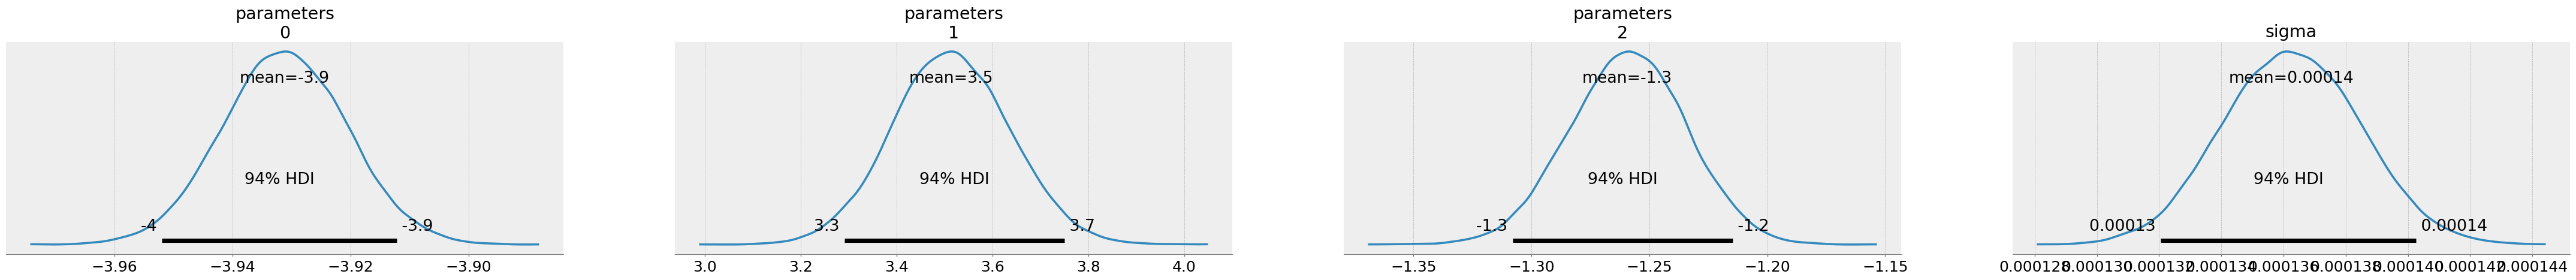

In [15]:
with basic_model:
    az.plot_posterior(trace,
                  var_names=['parameters','sigma'],
                  textsize=18,
                  point_estimate='mean',
                  rope_color='black')

In [16]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
parameters[0],-3.931,0.011,-3.952,-3.912,0.000,0.000,11427.0,11262.0,1.0
parameters[1],3.514,0.123,3.291,3.750,0.001,0.001,7469.0,9688.0,1.0
parameters[2],-1.259,0.025,-1.308,-1.215,0.000,0.000,7206.0,9114.0,1.0
sigma,0.000,0.000,0.000,0.000,0.000,0.000,13929.0,12167.0,1.0


In [17]:
means = (trace.posterior['parameters'].data[0].mean(axis=0) + trace.posterior['parameters'].data[1].mean(axis=0))/2
means = {key:mean for key,mean in zip(columns,means)}

In [18]:
means

{'yvav': -3.931218615253411,
 'yuuv': 3.513929793400256,
 'yuv': -1.2593588121420627}

In [19]:
stds = (trace.posterior['parameters'].data[0].std(axis=0) + trace.posterior['parameters'].data[1].std(axis=0))/2
stds = {key:std for key,std in zip(columns,stds)}

In [20]:
stds

{'yvav': 0.010555540999883452,
 'yuuv': 0.12249611319590964,
 'yuv': 0.024891139053819143}

In [21]:
df_parameters = pd.concat([
pd.Series(means, name='Bayesian'),
pd.Series({key:derivatives[key] for key in means.keys()}, name='splitted OLS'),
pd.Series({key:regression.regression.params[key] for key in means.keys()}, name='OLS'),
    
], axis=1).transpose()

In [22]:
df_parameters

,yvav,yuuv,yuv
Bayesian,-3.931219,3.513930,-1.259359
splitted OLS,-3.888942,3.664677,-1.346556
OLS,-4.961268,0.169063,-0.258130


In [23]:
df_uncertainties = pd.concat([
pd.Series(stds, name='Bayesian'),
pd.Series({key:derivatives_std[key] for key in stds.keys()}, name='splitted OLS'),
pd.Series({key:regression.regression.bse[key] for key in stds.keys()}, name='OLS'),
    
], axis=1).transpose()

In [24]:
df_uncertainties

,yvav,yuuv,yuv
Bayesian,0.010556,0.122496,0.024891
splitted OLS,0.010662,0.362330,0.177935
OLS,0.507031,2.042901,0.544708
